**[Smoothing Helps greatly along with phy and IC loss]**
- Initial Zero-Shot PINN Setup:
    Started with a basic PINN using MLPs for both spatial and temporal branches to predict the solution of the 1D Burgers' equation in a pure zero-shot setting (one initial point → one target point).

- Physics Loss + Smoother Training:
    Introduced physics loss based on the Burgers' PDE to guide the model using governing equations, but initial results were noisy and inaccurate. Adjusted model depth and added a smoothness loss (second derivative penalty) to regularize and remove high-frequency noise.

- Balanced Loss & Converged Predictions:
    Carefully balanced the weights of the initial condition loss, physics loss, and smoothness loss, leading to stable training and accurate, smooth predictions that respect both the initial conditions and the underlying PDE.

In [64]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [65]:
ν = 0.1
L = 2.0
N = 128
x = np.linspace(-1, 1, N)
T = 1
dx = x[1] - x[0]

u0 = -0.5 * np.sin(np.pi * x)

dt = 1e-4
nt = int(0.5 / dt)
u = u0.copy()
for n in range(nt):
    u_x = (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)
    u_xx = (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2
    u = u + dt * (ν * u_xx - u * u_x)

u_true = u.copy()
print(f"Final u at t={nt*dt:.4f}s: {u_true}")


u0_torch = torch.tensor(u0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, N)
uT_torch = torch.tensor(u, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)   # (1, 1, N)

x_torch = torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)    # (1, 1, N)


Final u at t=0.5000s: [ 0.00556641  0.01669413  0.02780649  0.03889319  0.04994385  0.06094793
  0.07189475  0.08277342  0.09357277  0.10428137  0.11488746  0.12537889
  0.13574311  0.14596707  0.15603725  0.16593953  0.1756592   0.18518087
  0.19448843  0.20356501  0.21239289  0.22095346  0.22922719  0.23719354
  0.24483091  0.25211661  0.25902679  0.26553644  0.27161932  0.27724794
  0.28239358  0.28702628  0.29111489  0.29462707  0.29752945  0.29978768
  0.30136662  0.30223054  0.30234334  0.30166888  0.30017133  0.29781561
  0.29456789  0.29039612  0.2852707   0.27916519  0.272057    0.26392827
  0.25476669  0.24456635  0.23332856  0.22106275  0.20778712  0.19352938
  0.17832719  0.16222855  0.14529192  0.12758613  0.10919     0.0901918
  0.07068827  0.05078356  0.03058782  0.01021565 -0.01021565 -0.03058782
 -0.05078356 -0.07068827 -0.0901918  -0.10919    -0.12758613 -0.14529192
 -0.16222855 -0.17832719 -0.19352938 -0.20778712 -0.22106275 -0.23332856
 -0.24456635 -0.25476669 -0.26

In [66]:
class DeepONet1D(nn.Module):
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    def __init__(self):
        super(DeepONet1D, self).__init__()
        self.init_weights()
        self.branch = nn.Sequential(
            nn.Flatten(start_dim=1),                # (B, N)
            nn.Linear(N, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, N),                       # (B, N)
        )

        self.trunk = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 128),  # match spatial size
            nn.ReLU(),
            nn.Linear(128, 64),  # match spatial size
            nn.ReLU(),
            nn.Linear(64, 32),  # match spatial size
            nn.ReLU(),
            nn.Linear(32, N),  # match spatial size
        )

    def forward(self, u_in, t_in):
        b_out = self.branch(u_in)      # (B, N)
        t_out = self.trunk(t_in)       # (B, N)
        out = b_out * t_out            # (B, N)
        return out.unsqueeze(1)        # (B, 1, N)

model = DeepONet1D().to(device)
model.init_weights()


In [67]:
def compute_burgers_residual(model, u_in, t_in, ν, dx):
    u_pred = model(u_in, t_in).squeeze(0).squeeze(0)  # (N,)
    
    # Derivatives (periodic padding)
    u_pad = torch.cat([u_pred[-1:], u_pred, u_pred[:1]], dim=0)  # (N+2,)
    u_x = (u_pad[2:] - u_pad[:-2]) / (2 * dx)
    u_xx = (u_pad[2:] - 2 * u_pred + u_pad[:-2]) / dx**2

    residual = u_pred * u_x - ν * u_xx  # ∂u/∂t ≈ 0 for zero-shot
    loss_phy = torch.mean(residual ** 2)
    return loss_phy


In [68]:
def compute_smoothness_loss(u_pred, dx):
    """
    Computes smoothness loss by penalizing large spatial gradients (∂u/∂x).
    
    Args:
        u_pred: Tensor of shape (1, N_x) → predicted u(x, t) at target time
        dx: Spatial grid spacing
        
    Returns:
        Scalar smoothness loss (L2 norm of ∂u/∂x)
    """
    # Compute central differences for interior points
    dudx = (u_pred[:, 2:] - u_pred[:, :-2]) / (2 * dx)  # shape: (1, N_x - 2)
    
    loss_smooth = torch.mean(dudx ** 2)
    return loss_smooth


In [72]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

t0 = torch.tensor([[0.0]], dtype=torch.float32).to(device)    # (1,1)
tT = torch.tensor([[T]], dtype=torch.float32).to(device)      # (1,1)

epochs = 10000

for epoch in range(epochs):
    model.train()

    pred_init = model(u0_torch, t0)  # (1,1,N)
    pred_target = model(u0_torch, tT).squeeze(1)  # (1,1,N)
    # pred_target = model(X_init, t_target)  # → (1, N_x)

    ic_loss = mse(pred_init, u0_torch)
    phy_loss = compute_burgers_residual(model, u0_torch, t0, ν=ν, dx=dx)
    smooth_loss = compute_smoothness_loss(pred_target, dx=dx)

    if epoch < 150:
        phy_wt = 0
        smooth_wt = 0
    else:
        phy_wt = 1e-1 * (epoch - 150) / (epochs - 150)
        smooth_wt = 1e-5 * (epoch - 150) / (epochs - 150)


    total_loss = ic_loss + phy_loss * phy_wt + smooth_loss * smooth_wt

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0 or epoch == epochs - 1:
        print(f"[Epoch {epoch}] Total: {total_loss.item():.6f} | IC: {ic_loss.item():.6f} | Physics: {phy_loss.item():.6f} | Smoothness: {smooth_loss.item():.6f}")


[Epoch 0] Total: 0.012745 | IC: 0.012745 | Physics: 1.925509 | Smoothness: 0.561784
[Epoch 500] Total: 0.001534 | IC: 0.000170 | Physics: 0.383920 | Smoothness: 1.107214
[Epoch 1000] Total: 0.003987 | IC: 0.001292 | Physics: 0.312280 | Smoothness: 0.961951
[Epoch 1500] Total: 0.006193 | IC: 0.002043 | Physics: 0.302670 | Smoothness: 0.907071
[Epoch 2000] Total: 0.003340 | IC: 0.000262 | Physics: 0.163816 | Smoothness: 1.095132
[Epoch 2500] Total: 0.016021 | IC: 0.006120 | Physics: 0.414905 | Smoothness: 0.724233
[Epoch 3000] Total: 0.088657 | IC: 0.000562 | Physics: 3.044611 | Smoothness: 1.051465
[Epoch 3500] Total: 0.009766 | IC: 0.005699 | Physics: 0.119498 | Smoothness: 0.741019
[Epoch 4000] Total: 0.009458 | IC: 0.004817 | Physics: 0.118659 | Smoothness: 0.775936
[Epoch 4500] Total: 0.024549 | IC: 0.001131 | Physics: 0.530153 | Smoothness: 0.992726
[Epoch 5000] Total: 0.015856 | IC: 0.009532 | Physics: 0.128365 | Smoothness: 0.629323
[Epoch 5500] Total: 0.010930 | IC: 0.005728 | P

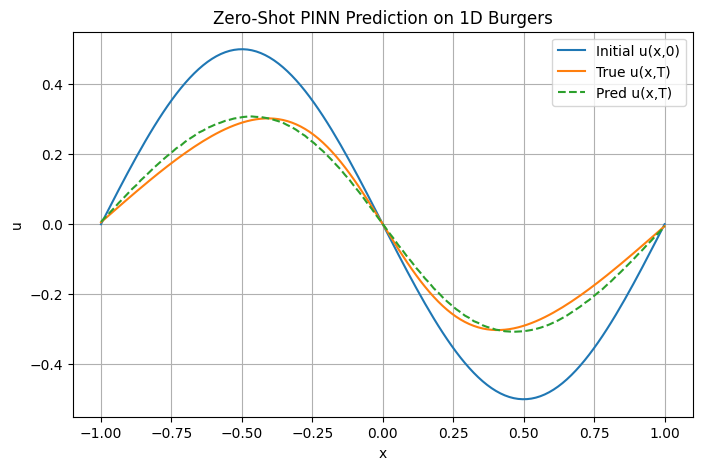

In [73]:
model.eval()
with torch.no_grad():
    pred_final = model(u0_torch, tT).cpu().numpy().squeeze()

plt.figure(figsize=(8,5))
plt.plot(x, u0, label='Initial u(x,0)')
plt.plot(x, u_true, label='True u(x,T)')
plt.plot(x, pred_final, '--', label='Pred u(x,T)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('Zero-Shot PINN Prediction on 1D Burgers')
plt.show()
